In [67]:
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
# Data = pd.read_csv('https://github.com/mathiasbruun/SDS19-Exam-Project/blob/master/Data_2018_csv.zip')
# url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/Data_2018_csv.zip'
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/data_16-07_19_04.zip'
Data = pd.read_csv(url, compression='zip')

C:\Users\Frederik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [53]:
Data['datetime'] = pd.to_datetime(Data['datetime'])
Df = Data.copy()
Df.set_index('datetime', drop = True, inplace=True)
Df.columns
Df['failure'] = ~Df.loc[:,'outcome'].isin(['A no further action disposal', 'False'])
Df = Df.loc[:,['age_range', 'gender', 'object_of_search', 'officer_defined_ethnicity', 'Force', 'type', 'failure']]

In [36]:
Df = pd.get_dummies(Df, drop_first=True)
Df['failure'] = Df.failure.astype(int)
X = Df.drop('failure', axis = 1)
y = Df['failure']

In [37]:
y.describe()

count    838934.000000
mean          0.315870
std           0.464862
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: failure, dtype: float64

In [38]:
from sklearn.model_selection import train_test_split
#split data in training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [48]:
# estimate model on train data, evaluate on test data
logr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
#train model
logr.fit(X_train, y_train)
#predict
y_hat = logr.predict(X_test)
#measure accuracy
accuracy = (y_hat==y_test).mean()
print('Model accuracy is:', np.round(accuracy,3))

C:\Users\Frederik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Frederik\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Frederik\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Model accuracy is: 0.687


In [ ]:
# split into development and test data
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

#Define lambdas
lambdas = np.logspace(-5, 5, 10)

# outer loop: lambdas
Accuracy = []
for lambda_ in tqdm(lambdas):    
    # inner loop: folds
    Accuracy = []    
    for train_idx, val_idx in folds:        
        # train model and compute accuracy on test fold
        logr = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', C=lambda_, random_state=1))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        logr.fit(X_train, y_train)        
        Accuracy.append(logr.score(X_val, y_val))    
        
    # store result    
    Accuracy.append(Accuracy) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(Accuracy, index=lambdas)

In [49]:
score = logr.score(X_test, y_test)
print(score)

C:\Users\Frederik\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.6872761298551139


[[  2071  50795]
 [  1676 113245]]


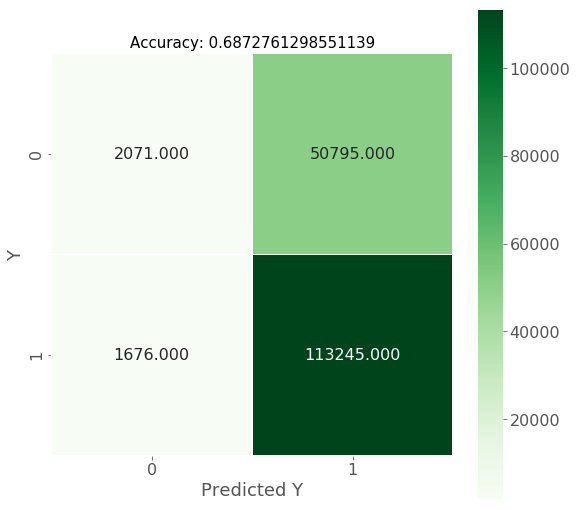

In [19]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
print(confusion_matrix)
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.1, square = True, cmap = 'Greens');
plt.ylabel('Y');
plt.xlabel('Predicted Y');
all_sample_title = 'Accuracy: {0}'.format(score)
plt.title(all_sample_title, size = 15);